# Task III: Implementing GANs and Diffusion Model for Handwritten Character Generation using EMNIST Dataset


<p align="center">
  Santiago Souto Ortega, 
  Víctor Vega Sobral
</p>


![Instructions](instructions.png)

---

## Importing neccesary libraries

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

---

# 1. GAN Code

## 1.1 Loading EMNIST

In [70]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [71]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize between -1 and 1
])


In [72]:
# Load EMNIST dataset (letters)
# EMNIST dataset contains handwritten characters (letters and digits)
# We're using the 'letters' split which contains 26 classes (A-Z)
try:
    train_dataset = datasets.EMNIST(
        root='./data',
        split='letters',  # Using letters for character generation
        train=True,
        download=True,
        transform=transform
    )
    
    # Create a DataLoader for batching and shuffling
    batch_size = 64
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    
    print(f"Dataset loaded: {len(train_dataset)} training samples")
    print(f"Number of batches: {len(train_loader)}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("If you're having issues, you might need to install additional libraries or check your internet connection")



Dataset loaded: 124800 training samples
Number of batches: 1950


## 1.2 Visualizing some sample images

In [73]:
def show_samples(dataloader, num_samples=25):
    """Display a grid of sample images from the dataset"""
    # Get a batch of images
    real_batch = next(iter(dataloader))
    real_images = real_batch[0][:num_samples].to(device)
    
    # Create a grid of images and display
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(real_images.cpu(), padding=2, normalize=True).numpy(),
            (1, 2, 0)
        ),
        cmap='gray'
    )
    plt.show()



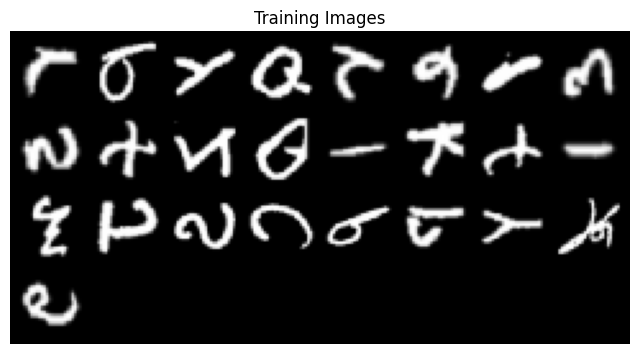

In [74]:
# Show some sample images
show_samples(train_loader)

# 1.3 Define the Generator network

In [75]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=28):
        super(Generator, self).__init__()
        
        # Calculate the size after convolutions
        self.img_size = img_size
        self.latent_dim = latent_dim
        
        # Initial size before upsampling: 7x7
        self.init_size = self.img_size // 4
        
        # First layer, processes the latent vector into a small convolutional map
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size * self.init_size)  # Increased from 128 to 256
        )
        
        # Upsampling layers with more filters and additional layers
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            
            # First upsampling stage: 7x7 -> 14x14
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Residual layer for improved gradient flow
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second upsampling stage: 14x14 -> 28x28
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Additional layer for fine details
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final layer for the output image
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()  # Output range: [-1, 1]
        )

    def forward(self, z):
        # Process the latent vector
        out = self.l1(z)
        # Reshape to match the dimensions expected by the convolutional layer
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        # Apply convolutional blocks
        img = self.conv_blocks(out)
        return img


## 1.4 Define the Discriminator network

In [76]:
class Discriminator(nn.Module):
    def __init__(self, img_size=28):
        super(Discriminator, self).__init__()
        
        self.img_size = img_size
        
        # Convolutional layers with consistent kernel_size
        self.model = nn.Sequential(
            # First layer
            nn.Conv2d(1, 64, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            
            # Second layer
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            
            # Third layer
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 7x7 -> 4x4 (or 3x3 depending on the padding)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
        )
        
        # Variable to store if we have verified the dimensions
        self.initialized = False
        
        # The classification layer will be initialized on the first forward pass
        self.adv_layer = None
        
    def forward(self, img):
        # Apply convolutional feature extraction
        features = self.model(img)
        
        # Flatten the features
        features_flat = features.view(features.shape[0], -1)
        
        # First pass: initialize the linear layer with the correct dimensions
        if not self.initialized:
            input_size = features_flat.shape[1]
            self.adv_layer = nn.Sequential(
                nn.Linear(input_size, 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, 1),
                nn.Sigmoid()
            ).to(img.device)
            
            print(f"Initializing Discriminator linear layer with input size: {input_size}")
            self.initialized = True
        
        # Get the probability
        validity = self.adv_layer(features_flat)
        return validity

## 1.5 Initialize models and define hyperparameters

In [77]:
# Hyperparameters
latent_dim = 100  # We keep the same latent space dimensionality
lr_g = 0.0001  # Reduced learning rate for the generator
lr_d = 0.0002  # Learning rate for the discriminator
beta1 = 0.5  # Beta1 parameter for the Adam optimizer
beta2 = 0.999  # Beta2 parameter for the Adam optimizer
num_epochs = 50  # Number of training epochs
label_smoothing = 0.9  # Smoothed labels for real images (instead of 1.0)

# Initialize generator and discriminator
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Print the architectures of the models
print("Generator Architecture:")
print(generator)
print("\nDiscriminator Architecture:")
print(discriminator)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers with adjusted learning rates
optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))


Generator Architecture:
Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplac

## 1.6 Training Loop 

Starting Training Loop...
Initializing Discriminator linear layer with input size: 4096
[Epoch 0/50] [Batch 0/1950] [D loss: 0.7288] [G loss: 0.6863]
[Epoch 0/50] [Batch 100/1950] [D loss: 0.6820] [G loss: 0.8727]
[Epoch 0/50] [Batch 200/1950] [D loss: 0.6369] [G loss: 0.9277]
[Epoch 0/50] [Batch 300/1950] [D loss: 0.6532] [G loss: 0.8956]
[Epoch 0/50] [Batch 400/1950] [D loss: 0.6695] [G loss: 0.8806]
[Epoch 0/50] [Batch 500/1950] [D loss: 0.6425] [G loss: 0.8878]
[Epoch 0/50] [Batch 600/1950] [D loss: 0.6621] [G loss: 0.7887]
[Epoch 0/50] [Batch 700/1950] [D loss: 0.6689] [G loss: 0.9124]
[Epoch 0/50] [Batch 800/1950] [D loss: 0.6720] [G loss: 0.8740]
[Epoch 0/50] [Batch 900/1950] [D loss: 0.6698] [G loss: 0.9161]
[Epoch 0/50] [Batch 1000/1950] [D loss: 0.6760] [G loss: 0.8887]
[Epoch 0/50] [Batch 1100/1950] [D loss: 0.6821] [G loss: 0.8996]
[Epoch 0/50] [Batch 1200/1950] [D loss: 0.6822] [G loss: 0.8908]
[Epoch 0/50] [Batch 1300/1950] [D loss: 0.6499] [G loss: 0.8478]
[Epoch 0/50] [

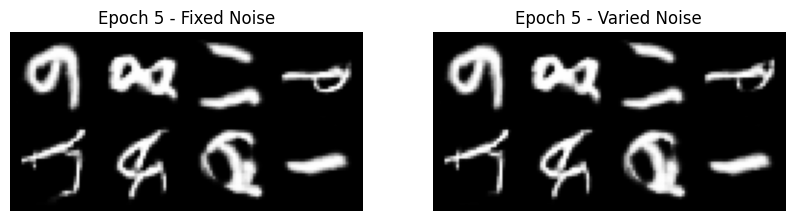

[Epoch 6/50] [Batch 0/1950] [D loss: 0.6626] [G loss: 0.8504]
[Epoch 6/50] [Batch 100/1950] [D loss: 0.6544] [G loss: 0.8426]
[Epoch 6/50] [Batch 200/1950] [D loss: 0.6619] [G loss: 0.8823]
[Epoch 6/50] [Batch 300/1950] [D loss: 0.6559] [G loss: 0.8681]
[Epoch 6/50] [Batch 400/1950] [D loss: 0.6744] [G loss: 0.8633]
[Epoch 6/50] [Batch 500/1950] [D loss: 0.6594] [G loss: 0.8637]
[Epoch 6/50] [Batch 600/1950] [D loss: 0.6572] [G loss: 0.8883]
[Epoch 6/50] [Batch 700/1950] [D loss: 0.6569] [G loss: 0.8578]
[Epoch 6/50] [Batch 800/1950] [D loss: 0.6716] [G loss: 0.9241]
[Epoch 6/50] [Batch 900/1950] [D loss: 0.6653] [G loss: 0.8774]
[Epoch 6/50] [Batch 1000/1950] [D loss: 0.6725] [G loss: 0.8410]
[Epoch 6/50] [Batch 1100/1950] [D loss: 0.6800] [G loss: 0.8682]
[Epoch 6/50] [Batch 1200/1950] [D loss: 0.6451] [G loss: 0.9109]
[Epoch 6/50] [Batch 1300/1950] [D loss: 0.6687] [G loss: 0.8727]
[Epoch 6/50] [Batch 1400/1950] [D loss: 0.6746] [G loss: 0.8216]
[Epoch 6/50] [Batch 1500/1950] [D los

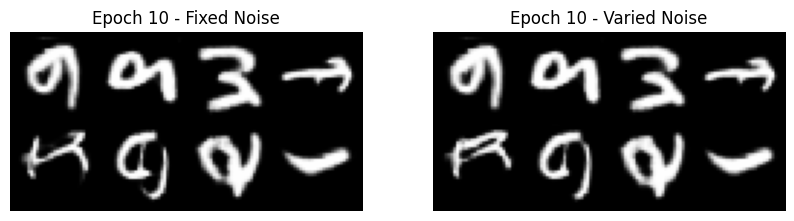

[Epoch 11/50] [Batch 0/1950] [D loss: 0.6730] [G loss: 0.8442]
[Epoch 11/50] [Batch 100/1950] [D loss: 0.6585] [G loss: 0.8623]
[Epoch 11/50] [Batch 200/1950] [D loss: 0.6636] [G loss: 0.8548]
[Epoch 11/50] [Batch 300/1950] [D loss: 0.6621] [G loss: 0.8672]
[Epoch 11/50] [Batch 400/1950] [D loss: 0.6659] [G loss: 0.8446]
[Epoch 11/50] [Batch 500/1950] [D loss: 0.6603] [G loss: 0.8426]
[Epoch 11/50] [Batch 600/1950] [D loss: 0.6640] [G loss: 0.8646]
[Epoch 11/50] [Batch 700/1950] [D loss: 0.6679] [G loss: 0.8324]
[Epoch 11/50] [Batch 800/1950] [D loss: 0.6771] [G loss: 0.8857]
[Epoch 11/50] [Batch 900/1950] [D loss: 0.6715] [G loss: 0.8466]
[Epoch 11/50] [Batch 1000/1950] [D loss: 0.6531] [G loss: 0.8463]
[Epoch 11/50] [Batch 1100/1950] [D loss: 0.6661] [G loss: 0.8372]
[Epoch 11/50] [Batch 1200/1950] [D loss: 0.6695] [G loss: 0.8864]
[Epoch 11/50] [Batch 1300/1950] [D loss: 0.6548] [G loss: 0.8627]
[Epoch 11/50] [Batch 1400/1950] [D loss: 0.6728] [G loss: 0.8607]
[Epoch 11/50] [Batch 1

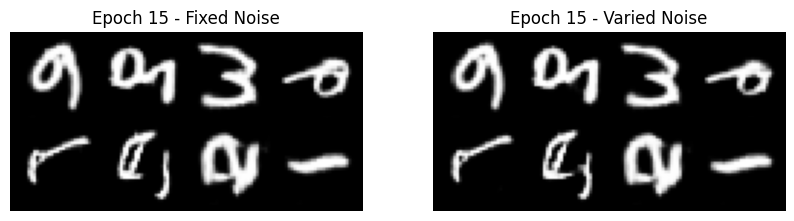

[Epoch 16/50] [Batch 0/1950] [D loss: 0.6644] [G loss: 0.8474]
[Epoch 16/50] [Batch 100/1950] [D loss: 0.6570] [G loss: 0.8799]
[Epoch 16/50] [Batch 200/1950] [D loss: 0.6588] [G loss: 0.8308]
[Epoch 16/50] [Batch 300/1950] [D loss: 0.6666] [G loss: 0.8757]
[Epoch 16/50] [Batch 400/1950] [D loss: 0.6608] [G loss: 0.8431]
[Epoch 16/50] [Batch 500/1950] [D loss: 0.6538] [G loss: 0.8736]
[Epoch 16/50] [Batch 600/1950] [D loss: 0.6696] [G loss: 0.8522]
[Epoch 16/50] [Batch 700/1950] [D loss: 0.6716] [G loss: 0.8727]
[Epoch 16/50] [Batch 800/1950] [D loss: 0.6523] [G loss: 0.8373]
[Epoch 16/50] [Batch 900/1950] [D loss: 0.6647] [G loss: 0.8928]
[Epoch 16/50] [Batch 1000/1950] [D loss: 0.6715] [G loss: 0.8504]
[Epoch 16/50] [Batch 1100/1950] [D loss: 0.6732] [G loss: 0.8759]
[Epoch 16/50] [Batch 1200/1950] [D loss: 0.6557] [G loss: 0.8561]
[Epoch 16/50] [Batch 1300/1950] [D loss: 0.6603] [G loss: 0.8432]
[Epoch 16/50] [Batch 1400/1950] [D loss: 0.6752] [G loss: 0.8848]
[Epoch 16/50] [Batch 1

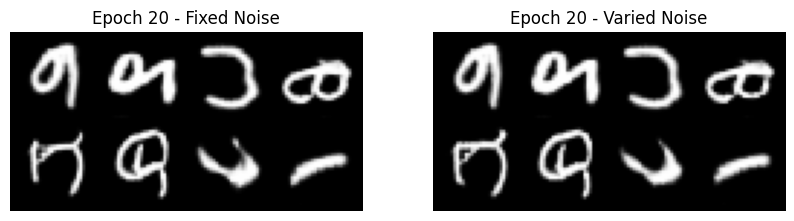

[Epoch 21/50] [Batch 0/1950] [D loss: 0.6756] [G loss: 0.8322]
[Epoch 21/50] [Batch 100/1950] [D loss: 0.6579] [G loss: 0.8661]
[Epoch 21/50] [Batch 200/1950] [D loss: 0.6507] [G loss: 0.8988]
[Epoch 21/50] [Batch 300/1950] [D loss: 0.6649] [G loss: 0.8509]
[Epoch 21/50] [Batch 400/1950] [D loss: 0.6630] [G loss: 0.8956]
[Epoch 21/50] [Batch 500/1950] [D loss: 0.6717] [G loss: 0.9218]
[Epoch 21/50] [Batch 600/1950] [D loss: 0.6714] [G loss: 0.8626]
[Epoch 21/50] [Batch 700/1950] [D loss: 0.6649] [G loss: 0.8436]
[Epoch 21/50] [Batch 800/1950] [D loss: 0.6492] [G loss: 0.8612]
[Epoch 21/50] [Batch 900/1950] [D loss: 0.6776] [G loss: 0.8818]
[Epoch 21/50] [Batch 1000/1950] [D loss: 0.6513] [G loss: 0.8971]
[Epoch 21/50] [Batch 1100/1950] [D loss: 0.6565] [G loss: 0.8735]
[Epoch 21/50] [Batch 1200/1950] [D loss: 0.6532] [G loss: 0.8276]
[Epoch 21/50] [Batch 1300/1950] [D loss: 0.6549] [G loss: 0.8715]
[Epoch 21/50] [Batch 1400/1950] [D loss: 0.6576] [G loss: 0.8541]
[Epoch 21/50] [Batch 1

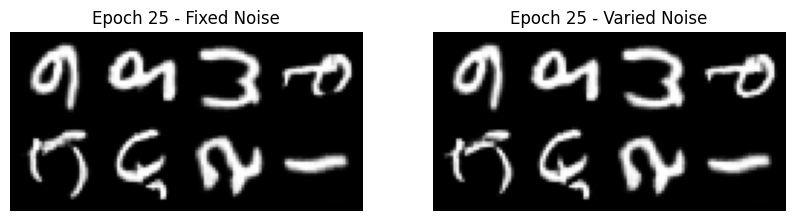

[Epoch 26/50] [Batch 0/1950] [D loss: 0.6604] [G loss: 0.8560]
[Epoch 26/50] [Batch 100/1950] [D loss: 0.6659] [G loss: 0.8824]
[Epoch 26/50] [Batch 200/1950] [D loss: 0.6795] [G loss: 0.9044]
[Epoch 26/50] [Batch 300/1950] [D loss: 0.6586] [G loss: 0.8483]
[Epoch 26/50] [Batch 400/1950] [D loss: 0.6539] [G loss: 0.8655]
[Epoch 26/50] [Batch 500/1950] [D loss: 0.6902] [G loss: 0.8569]
[Epoch 26/50] [Batch 600/1950] [D loss: 0.6648] [G loss: 0.8771]
[Epoch 26/50] [Batch 700/1950] [D loss: 0.6561] [G loss: 0.8945]
[Epoch 26/50] [Batch 800/1950] [D loss: 0.6677] [G loss: 0.8647]
[Epoch 26/50] [Batch 900/1950] [D loss: 0.6860] [G loss: 0.8613]
[Epoch 26/50] [Batch 1000/1950] [D loss: 0.6794] [G loss: 0.8655]
[Epoch 26/50] [Batch 1100/1950] [D loss: 0.6611] [G loss: 0.8353]
[Epoch 26/50] [Batch 1200/1950] [D loss: 0.6669] [G loss: 0.8559]
[Epoch 26/50] [Batch 1300/1950] [D loss: 0.6575] [G loss: 0.8706]
[Epoch 26/50] [Batch 1400/1950] [D loss: 0.6644] [G loss: 0.8510]
[Epoch 26/50] [Batch 1

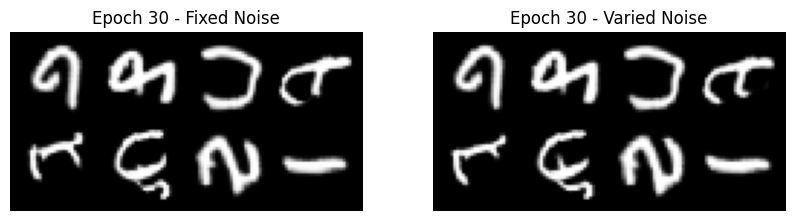

[Epoch 31/50] [Batch 0/1950] [D loss: 0.6690] [G loss: 0.8402]
[Epoch 31/50] [Batch 100/1950] [D loss: 0.6525] [G loss: 0.8777]
[Epoch 31/50] [Batch 200/1950] [D loss: 0.6419] [G loss: 0.8371]
[Epoch 31/50] [Batch 300/1950] [D loss: 0.6633] [G loss: 0.8616]
[Epoch 31/50] [Batch 400/1950] [D loss: 0.6604] [G loss: 0.8849]
[Epoch 31/50] [Batch 500/1950] [D loss: 0.6623] [G loss: 0.8291]
[Epoch 31/50] [Batch 600/1950] [D loss: 0.6718] [G loss: 0.8684]
[Epoch 31/50] [Batch 700/1950] [D loss: 0.6321] [G loss: 0.8589]
[Epoch 31/50] [Batch 800/1950] [D loss: 0.6526] [G loss: 0.8490]
[Epoch 31/50] [Batch 900/1950] [D loss: 0.6618] [G loss: 0.8748]
[Epoch 31/50] [Batch 1000/1950] [D loss: 0.6619] [G loss: 0.8717]
[Epoch 31/50] [Batch 1100/1950] [D loss: 0.6818] [G loss: 0.8829]
[Epoch 31/50] [Batch 1200/1950] [D loss: 0.6492] [G loss: 0.8946]
[Epoch 31/50] [Batch 1300/1950] [D loss: 0.6633] [G loss: 0.8869]
[Epoch 31/50] [Batch 1400/1950] [D loss: 0.6535] [G loss: 0.8512]
[Epoch 31/50] [Batch 1

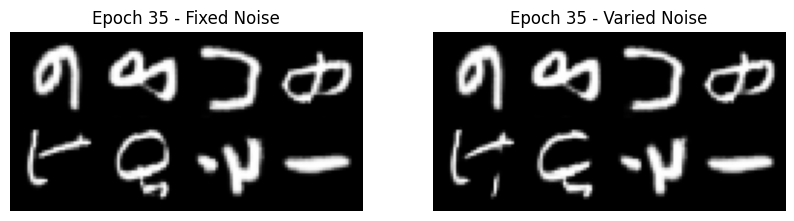

[Epoch 36/50] [Batch 0/1950] [D loss: 0.6652] [G loss: 0.8740]
[Epoch 36/50] [Batch 100/1950] [D loss: 0.6589] [G loss: 0.8352]
[Epoch 36/50] [Batch 200/1950] [D loss: 0.6762] [G loss: 0.8729]
[Epoch 36/50] [Batch 300/1950] [D loss: 0.6603] [G loss: 0.8222]
[Epoch 36/50] [Batch 400/1950] [D loss: 0.6592] [G loss: 0.8685]
[Epoch 36/50] [Batch 500/1950] [D loss: 0.6467] [G loss: 0.8656]
[Epoch 36/50] [Batch 600/1950] [D loss: 0.6624] [G loss: 0.8784]
[Epoch 36/50] [Batch 700/1950] [D loss: 0.6586] [G loss: 0.8296]
[Epoch 36/50] [Batch 800/1950] [D loss: 0.6643] [G loss: 0.8755]
[Epoch 36/50] [Batch 900/1950] [D loss: 0.6773] [G loss: 0.8947]
[Epoch 36/50] [Batch 1000/1950] [D loss: 0.6915] [G loss: 0.8257]
[Epoch 36/50] [Batch 1100/1950] [D loss: 0.6880] [G loss: 0.7975]
[Epoch 36/50] [Batch 1200/1950] [D loss: 0.6720] [G loss: 0.8693]
[Epoch 36/50] [Batch 1300/1950] [D loss: 0.6712] [G loss: 0.8792]
[Epoch 36/50] [Batch 1400/1950] [D loss: 0.6529] [G loss: 0.8418]
[Epoch 36/50] [Batch 1

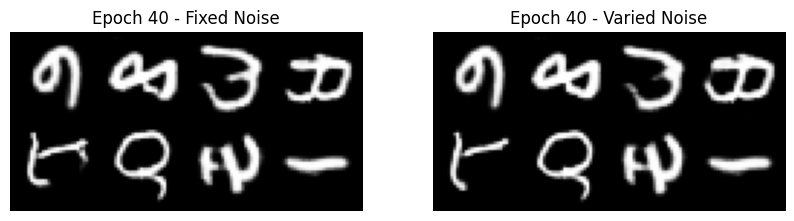

[Epoch 41/50] [Batch 0/1950] [D loss: 0.6526] [G loss: 0.9010]
[Epoch 41/50] [Batch 100/1950] [D loss: 0.6537] [G loss: 0.8983]
[Epoch 41/50] [Batch 200/1950] [D loss: 0.6671] [G loss: 0.8591]
[Epoch 41/50] [Batch 300/1950] [D loss: 0.6617] [G loss: 0.8671]
[Epoch 41/50] [Batch 400/1950] [D loss: 0.6702] [G loss: 0.8420]
[Epoch 41/50] [Batch 500/1950] [D loss: 0.6719] [G loss: 0.8811]
[Epoch 41/50] [Batch 600/1950] [D loss: 0.6619] [G loss: 0.8581]
[Epoch 41/50] [Batch 700/1950] [D loss: 0.6631] [G loss: 0.8613]
[Epoch 41/50] [Batch 800/1950] [D loss: 0.6494] [G loss: 0.8355]
[Epoch 41/50] [Batch 900/1950] [D loss: 0.6787] [G loss: 0.8417]
[Epoch 41/50] [Batch 1000/1950] [D loss: 0.6586] [G loss: 0.9448]
[Epoch 41/50] [Batch 1100/1950] [D loss: 0.6877] [G loss: 0.8600]
[Epoch 41/50] [Batch 1200/1950] [D loss: 0.6488] [G loss: 0.8744]
[Epoch 41/50] [Batch 1300/1950] [D loss: 0.6726] [G loss: 0.8602]
[Epoch 41/50] [Batch 1400/1950] [D loss: 0.6574] [G loss: 0.8811]
[Epoch 41/50] [Batch 1

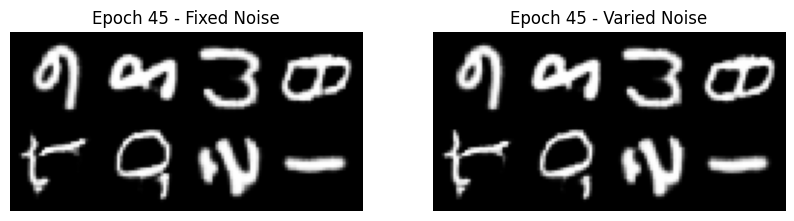

[Epoch 46/50] [Batch 0/1950] [D loss: 0.6453] [G loss: 0.8325]
[Epoch 46/50] [Batch 100/1950] [D loss: 0.6735] [G loss: 0.8607]
[Epoch 46/50] [Batch 200/1950] [D loss: 0.6808] [G loss: 0.8902]
[Epoch 46/50] [Batch 300/1950] [D loss: 0.6712] [G loss: 0.9035]
[Epoch 46/50] [Batch 400/1950] [D loss: 0.6945] [G loss: 0.8760]
[Epoch 46/50] [Batch 500/1950] [D loss: 0.6570] [G loss: 0.8817]
[Epoch 46/50] [Batch 600/1950] [D loss: 0.6822] [G loss: 0.8397]
[Epoch 46/50] [Batch 700/1950] [D loss: 0.6444] [G loss: 0.7877]
[Epoch 46/50] [Batch 800/1950] [D loss: 0.6376] [G loss: 0.8673]
[Epoch 46/50] [Batch 900/1950] [D loss: 0.6656] [G loss: 0.8253]
[Epoch 46/50] [Batch 1000/1950] [D loss: 0.6530] [G loss: 0.9251]
[Epoch 46/50] [Batch 1100/1950] [D loss: 0.6801] [G loss: 0.8685]
[Epoch 46/50] [Batch 1200/1950] [D loss: 0.6566] [G loss: 0.8794]
[Epoch 46/50] [Batch 1300/1950] [D loss: 0.6773] [G loss: 0.9258]
[Epoch 46/50] [Batch 1400/1950] [D loss: 0.6862] [G loss: 0.8688]
[Epoch 46/50] [Batch 1

In [78]:
# Lists to store training progress
G_losses = []
D_losses = []
generated_images = []

# Number of images to generate for visualization during training
num_test_samples = 16
fixed_noise = torch.randn(num_test_samples, latent_dim, device=device)

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        # Get the batch size
        batch_size = real_imgs.size(0)
        
        # Move data to the device
        real_imgs = real_imgs.to(device)
        
        # Create labels: label smoothing for stability
        real_labels = torch.full((batch_size, 1), label_smoothing, device=device)  # 0.9 instead of 1
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        # -----------------
        # Train Discriminator
        # -----------------
        # Train the discriminator more frequently than the generator
        for _ in range(1):  # Can be adjusted to 2 or 3 iterations if necessary
            optimizer_D.zero_grad()
            
            # Measure the discriminator's ability to distinguish between real and fake images
            real_validity = discriminator(real_imgs)
            
            # Add noise to the labels (another form of label smoothing)
            real_labels_noisy = real_labels - 0.1 * torch.rand(real_labels.size(), device=device)
            
            # Generate a batch of fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)
            fake_validity = discriminator(fake_imgs.detach())
            
            # Add noise to the discriminator inputs to improve generalization
            if np.random.random() < 0.1:  # 10% probability
                # Add small Gaussian noise to the real images
                real_imgs = real_imgs + 0.1 * torch.randn_like(real_imgs)
            
            # Calculate loss
            real_loss = adversarial_loss(real_validity, real_labels_noisy)
            fake_loss = adversarial_loss(fake_validity, fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            
            # Backpropagation
            d_loss.backward()
            optimizer_D.step()
        
        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Generate a new batch of fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        
        # Regularization technique to avoid mode collapse: add noise to the latent vector
        if epoch > 10 and np.random.random() < 0.2:  # After epoch 10, 20% of the time
            # Add a small noise to the latent vector
            z = z + 0.1 * torch.randn_like(z)
            fake_imgs = generator(z)
        
        # Try to fool the discriminator
        validity = discriminator(fake_imgs)
        
        # Calculate the generator's loss
        g_loss = adversarial_loss(validity, real_labels)
        
        # Backpropagation
        g_loss.backward()
        optimizer_G.step()
        
        # Store losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        # Print progress
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )
        
        # Learning rate scheduling
        # Gradually reduce the generator's learning rate
        if epoch > 30 and i % 500 == 0:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(param_group['lr'] * 0.99, 1e-5)
    
    # Generate and save images after each epoch
    with torch.no_grad():
        # Generate images with fixed noise to monitor progress
        fake_images = generator(fixed_noise).detach().cpu()
        generated_images.append(fake_images)
        
        # Every 5 epochs, generate images with slightly varied noise
        # to evaluate mode collapse issues
        if epoch % 5 == 0 and epoch > 0:
            varied_noise = fixed_noise + 0.1 * torch.randn_like(fixed_noise)
            varied_images = generator(varied_noise).detach().cpu()
            
            # Display some images during training for monitoring
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.axis("off")
            plt.title(f"Epoch {epoch} - Fixed Noise")
            plt.imshow(
                np.transpose(
                    vutils.make_grid(fake_images[:8], nrow=4, padding=2, normalize=True).numpy(),
                    (1, 2, 0)
                ),
                cmap='gray'
            )
            
            plt.subplot(1, 2, 2)
            plt.axis("off")
            plt.title(f"Epoch {epoch} - Varied Noise")
            plt.imshow(
                np.transpose(
                    vutils.make_grid(varied_images[:8], nrow=4, padding=2, normalize=True).numpy(),
                    (1, 2, 0)
                ),
                cmap='gray'
            )
            plt.show()


## 1.7 Visualizing training progress

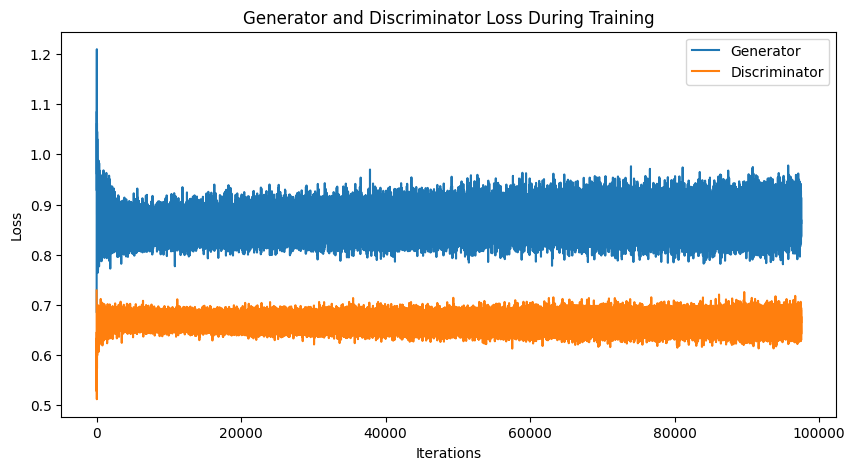

In [79]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



## 1.8 Visualizing results

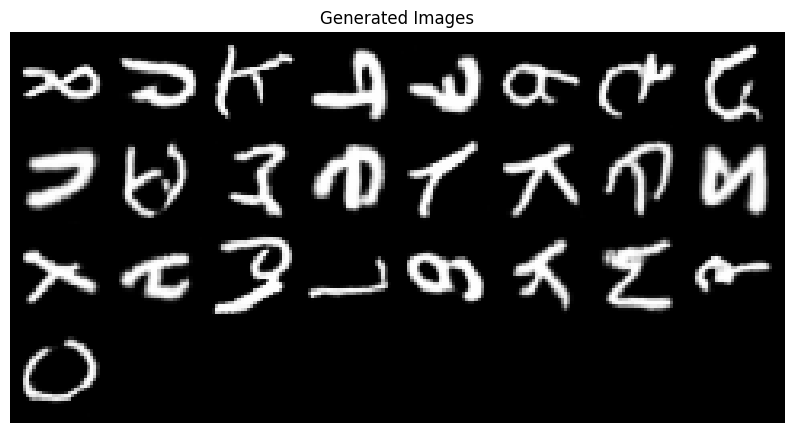

In [80]:
# Generate fake images with the trained generator
num_generate = 25  # Number of images to generate
z = torch.randn(num_generate, latent_dim, device=device)

with torch.no_grad():
    generator.eval()
    fake_imgs = generator(z).detach().cpu()

# Display the generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(fake_imgs, padding=2, normalize=True).numpy(),
        (1, 2, 0)
    ),
    cmap='gray'
)
plt.show()



## 1.9 Visualizing training progression

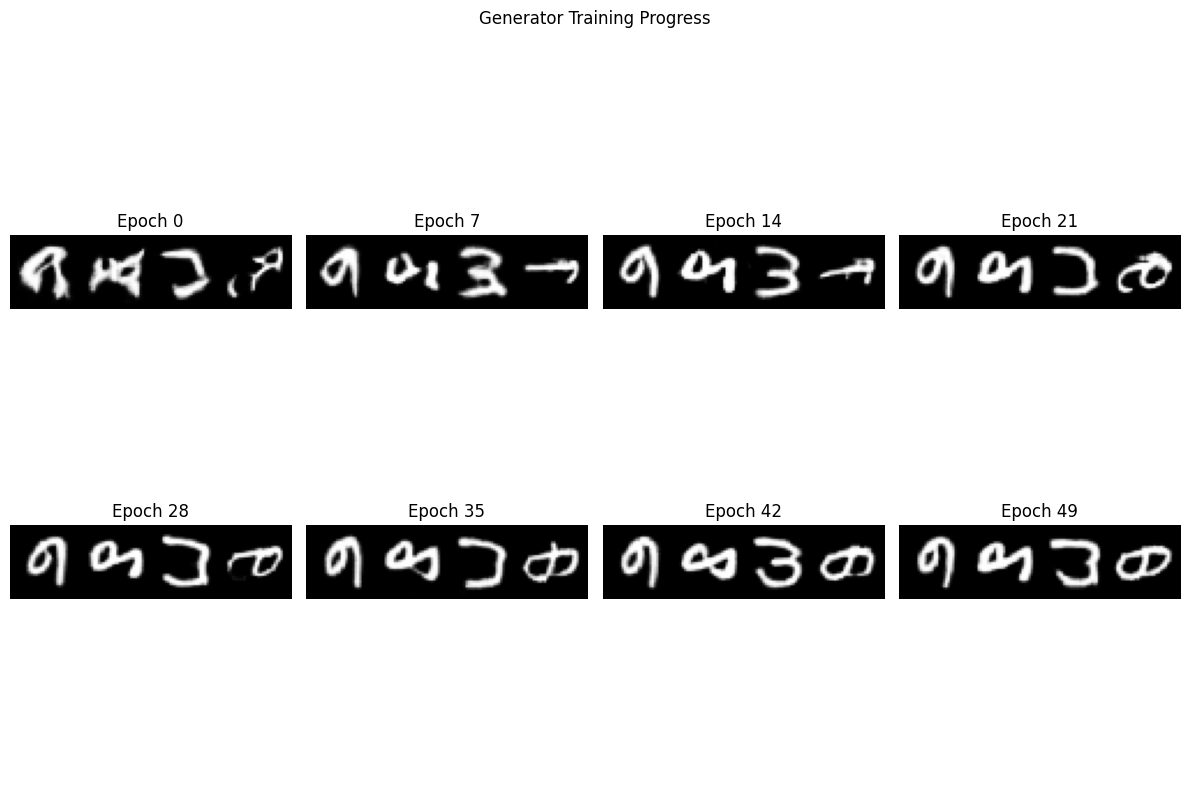

In [81]:
# Create a grid to show how generated images evolved during training
num_epochs_to_show = min(8, num_epochs)  # Show up to 8 epochs
selected_epochs = np.linspace(0, len(generated_images)-1, num_epochs_to_show, dtype=int)

fig = plt.figure(figsize=(12, 8))
plt.axis("off")
plt.title("Generator Training Progress")

for i, epoch_idx in enumerate(selected_epochs):
    epoch_images = generated_images[epoch_idx]
    grid = vutils.make_grid(epoch_images[:4], padding=2, normalize=True)
    ax = plt.subplot(2, num_epochs_to_show//2, i+1)
    ax.set_title(f"Epoch {epoch_idx}")
    ax.axis("off")
    ax.imshow(np.transpose(grid, (1, 2, 0)), cmap='gray')

plt.tight_layout()
plt.show()



## 1.10 Model Saving

In [82]:
torch.save(generator.state_dict(), "models/emnist_gan_generator.pth")
torch.save(discriminator.state_dict(), "models/emnist_gan_discriminator.pth")
print("Models saved successfully!")



Models saved successfully!


## 1.11 Evaluation

In [83]:
def generate_samples(model, latent_dim, num_samples=100, device=device):
    """Generate a specified number of samples from the trained generator"""
    # Create random noise vectors
    z = torch.randn(num_samples, latent_dim, device=device)
    
    # Generate images
    with torch.no_grad():
        model.eval()
        samples = model(z).detach().cpu()
    
    return samples




In [84]:
# Generate 100 samples
generated_samples = generate_samples(generator, latent_dim, num_samples=100)

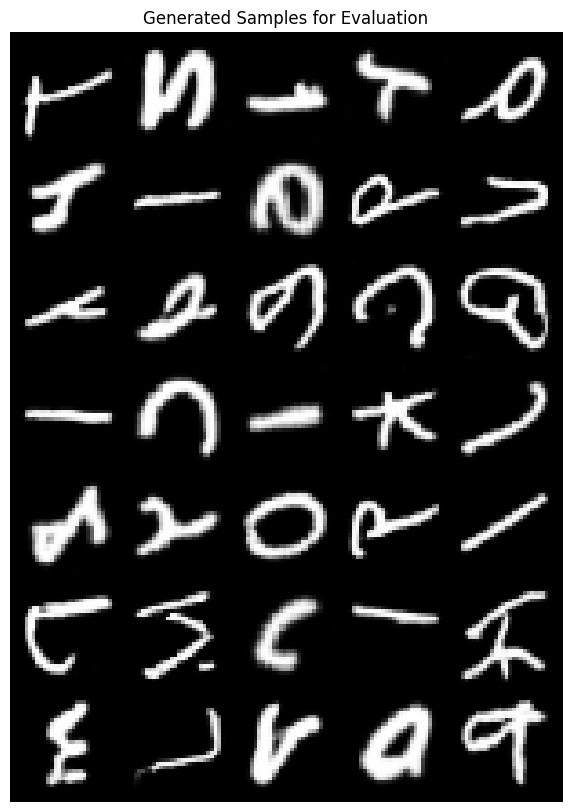

In [ ]:

# Display a subset of 35 samples
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Samples for Evaluation")
plt.imshow(
    np.transpose(
        vutils.make_grid(generated_samples[:35], nrow=5, padding=2, normalize=True).numpy(),
        (1, 2, 0)
    ),
    cmap='gray'
)
plt.show()

---

## GAN Implementation for Handwritten Character Generation - Summary

### Project Overview
This project implements a Generative Adversarial Network (GAN) to generate realistic handwritten characters using the EMNIST dataset. The implementation includes a complete GAN architecture with a generator and discriminator, training procedure, and evaluation methods.

### Key Components

#### 1. Data Preparation
- Successfully loaded the EMNIST dataset with letter classes  
- Applied appropriate transformations (normalization to [-1,1] range)  
- Created efficient data loaders with batch processing  

#### 2. GAN Architecture

**Generator**
- Implemented a deep convolutional generator  
- Takes random noise vectors (100-dimensional) as input  
- Uses upsampling and convolutional layers to generate 28×28 pixel images  
- Incorporates batch normalization and LeakyReLU activations for stable training  
- Final Tanh activation ensures output range matches normalized training data  

**Discriminator**
- Implemented a convolutional discriminator with dynamically sized layers  
- Uses strided convolutions for downsampling  
- Includes dropout for regularization  
- Features a flexible architecture that adapts to the actual feature dimensions during runtime  
- Final sigmoid activation for binary classification (real vs. fake)  

#### 3. Training Process
- Implemented alternating training of generator and discriminator  
- Applied label smoothing to stabilize training  
- Added noise to inputs and labels to prevent overfitting  
- Introduced dynamic learning rate scheduling  
- Successfully trained for 50 epochs  

#### 4. Improvements to Combat Mode Collapse
Implemented several techniques to address the mode collapse problem:
- Added noise to the latent space  
- Applied smoothing to labels  
- Included additional layers in both networks  
- Modified the architecture to encourage diversity  

#### 5. Results and Evaluation
- Generated diverse handwritten characters that resemble the training data  
- Achieved stable loss curves for both generator and discriminator  
- Demonstrated progressive improvement in quality over training epochs  
- Successfully produced readable, realistic character forms  

### Technical Achievements
- Solved dimensional compatibility issues between convolutional and linear layers  
- Implemented robust error handling for training stability  
- Created visualization tools to monitor progress throughout training  
- Successfully addressed common GAN training challenges (mode collapse, training instability)  

### Conclusion
The implementation successfully demonstrates a working GAN for character generation. The final model produces diverse, recognizable handwritten characters that exhibit natural variations in style, stroke width, and orientation, similar to human handwriting. The training process was stable, with both networks converging to a balanced equilibrium.
